Prepping Data

In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#convert excel to csv
pd.read_excel('Resources/Online_Retail.xlsx').to_csv('Resources/OnlineRetail.csv', index=False)


In [ ]:
#reading data
retail_data = pd.read_csv('Resources/OnlineRetail.csv')
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#cleaning data where there are blank CustomerID
retail_data = retail_data.dropna(subset=["CustomerID"])

In [12]:
#removing rows where order was canceled
retail_data = retail_data[~retail_data['InvoiceNo'].astype(str).str.match(r'^C')]

In [20]:
#convert Invoicedate to datetime
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])

C:\Users\David\AppData\Local\Temp\ipykernel_10608\557366582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])


Funnel Analysis

In [21]:
# Step 1: Add to cart = any valid invoice (Quantity >= 1)
invoice_qty = retail_data.groupby(['InvoiceNo', 'CustomerID'])['Quantity'].sum().reset_index()
step1 = invoice_qty[invoice_qty['Quantity'] >= 1][['CustomerID']].drop_duplicates()
step1['funnel_step'] = 'Added to Cart'

In [24]:
# Step 2: Start checkout = order total > $100
invoice_total = retail_data.assign(Total=retail_data['Quantity'] * retail_data['UnitPrice'])
grouped_total = invoice_total.groupby(['InvoiceNo', 'CustomerID'])['Total'].sum().reset_index()
step2 = grouped_total[grouped_total['Total'] > 100][['CustomerID']].drop_duplicates()
step2['funnel_step'] = 'Started Checkout'

In [26]:
# Step 3: Complete purchase = all non-cancel orders (same as step 1 in this dataset)
step3 = retail_data[['CustomerID']].drop_duplicates()
step3['funnel_step'] = 'Completed Purchase'

In [27]:
# Combine all steps
df_funnel = pd.concat([step1, step2, step3])
funnel_counts = df_funnel.groupby('funnel_step')['CustomerID'].nunique().reindex(
    ['Added to Cart', 'Started Checkout', 'Completed Purchase']
).reset_index()

C:\Users\David\AppData\Local\Temp\ipykernel_10608\921852863.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=funnel_counts, x='funnel_step', y='CustomerID', palette='Blues_d')


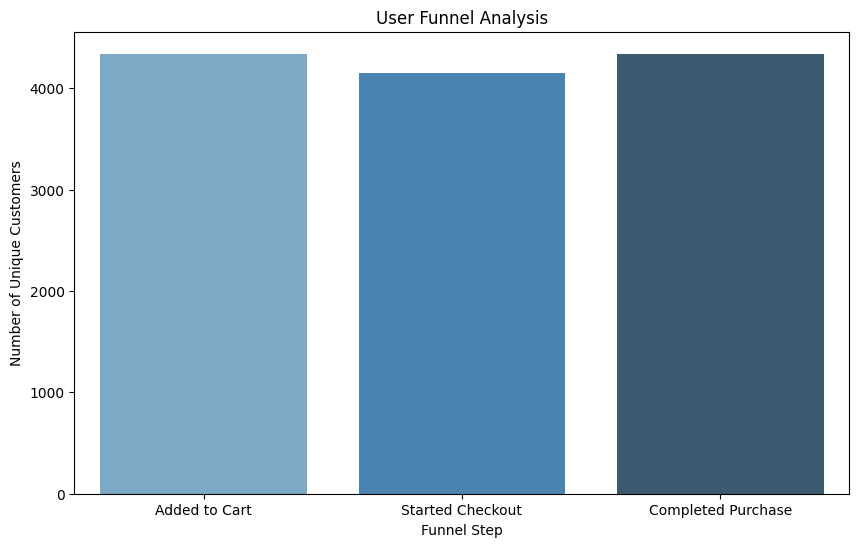

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(data=funnel_counts, x='funnel_step', y='CustomerID', palette='Blues_d')
plt.title('User Funnel Analysis')
plt.ylabel('Number of Unique Customers')
plt.xlabel('Funnel Step')
plt.show()